In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns
import sys
import scipy.stats as stats
import pickle

In [2]:
dataset = 'mdcd_3yrs'


# ALL FEATURES

In [3]:
df_scores = pd.read_csv(f'{afo_load_path}/complete_importance_dfs.csv', index_col = 0)
df_scores.set_index('feature', inplace=True)
output_folder = f'figures_skiptrain_6mo_fullfeatures/'
with open(f'{int_data_path}/9_26_mdcd_2dx_fullhistory_du_snomed_colnames', "rb") as fp:   #Pickling
    data_columns = pickle.load(fp)

In [4]:
# get overall importance

overall_mean_scores = df_scores['overall_mean'].loc[data_columns]
overall_sem_scores = df_scores['overall_sem'].loc[data_columns]

overall_mean_scores.name = 'mean_scores'
overall_sem_scores.columns = ['sem_scores']
overall_rankings = pd.DataFrame(overall_mean_scores).merge(overall_sem_scores, how = 'outer', left_index=True, right_index=True)

overall_rankings = overall_rankings.sort_values('mean_scores', ascending=False)
top10_rankings = overall_rankings.sort_values('mean_scores', ascending=False).iloc[0:10]
print(top10_rankings.index)

top10_rankings['feature_name'] = ['Frequency of psychosis NOS dx (ICD 9)', 'Frequency of psychosis NOS dx (ICD 10)', 'Num days prescribed: \nAntispasmodics + psycholeptics', 
                                  'Num. days prescribed: Antipsychotics', 'Pharmacy visit frequency', 'Frequency of "perception disturbance" dx', 
                                 'Frequency of affective dx', 'ED visit frequency', 'Frequency of developmental \nmental disorder dx', 
                                 'Num. days prescribed: Psychostimulants']


Index(['Psychotic disorder_conds', 'Non-organic psychosis_conds',
       'ANTISPASMODICS IN COMBINATION WITH PSYCHOLEPTICS_meds',
       'ANTIPSYCHOTICS_meds', '581458_ALL_num_visits',
       'Perception AND/OR perception disturbance_conds', 'Mood finding_conds',
       '9203_ALL_num_visits', 'Developmental mental disorder_conds',
       'PSYCHOSTIMULANTS, AGENTS USED FOR ADHD AND NOOTROPICS_meds'],
      dtype='object', name='feature')


In [5]:
# get the association between the top features and the predicted outputs
df_data = pd.read_csv(f'{int_data_path}/causal_data/10_15_causal_raw_data.csv', usecols = ['person_id', 'iteration'] + list(top10_rankings.index))
test_outputs = pd.read_csv('results_fullfeatures/test_outputs.csv', parse_dates = ['date_prediction'])

df_tte = pd.read_csv(f'{int_data_path}/9_26_mdcd_2dx_fullhistory_time_to_event.csv', parse_dates = ['interval_end_date'])
test_outputs = test_outputs.merge(df_tte[['person_id', 'interval_end_date', 'iteration']], left_on = ['person_id', 'date_prediction'], right_on = ['person_id', 'interval_end_date'], how = 'inner')
df_data = df_data.merge(test_outputs[['person_id', 'iteration', 'y_pred']], how = 'inner', on = ['person_id', 'iteration'])

correlations = []
ci_lower = []
ci_upper = []

for col in top10_rankings.index:
    r, p = stats.pearsonr(df_data[col], df_data['y_pred'])
    # calculate confidence interval
    n = len(df_data)
    se = 1 / np.sqrt(n - 3)  # Standard error
    z = np.arctanh(r)  # Fisher transformation
    z_critical = 1.96  # For 95% confidence
    z_lower = z - z_critical * se
    z_upper = z + z_critical * se
    ci_lower.append(np.tanh(z_lower))  # Transform back
    ci_upper.append(np.tanh(z_upper))  # Transform back
    correlations.append(r)

correlation_results = pd.DataFrame({
    'Variable': list(top10_rankings['feature_name']),
    'Correlation': correlations,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper
})

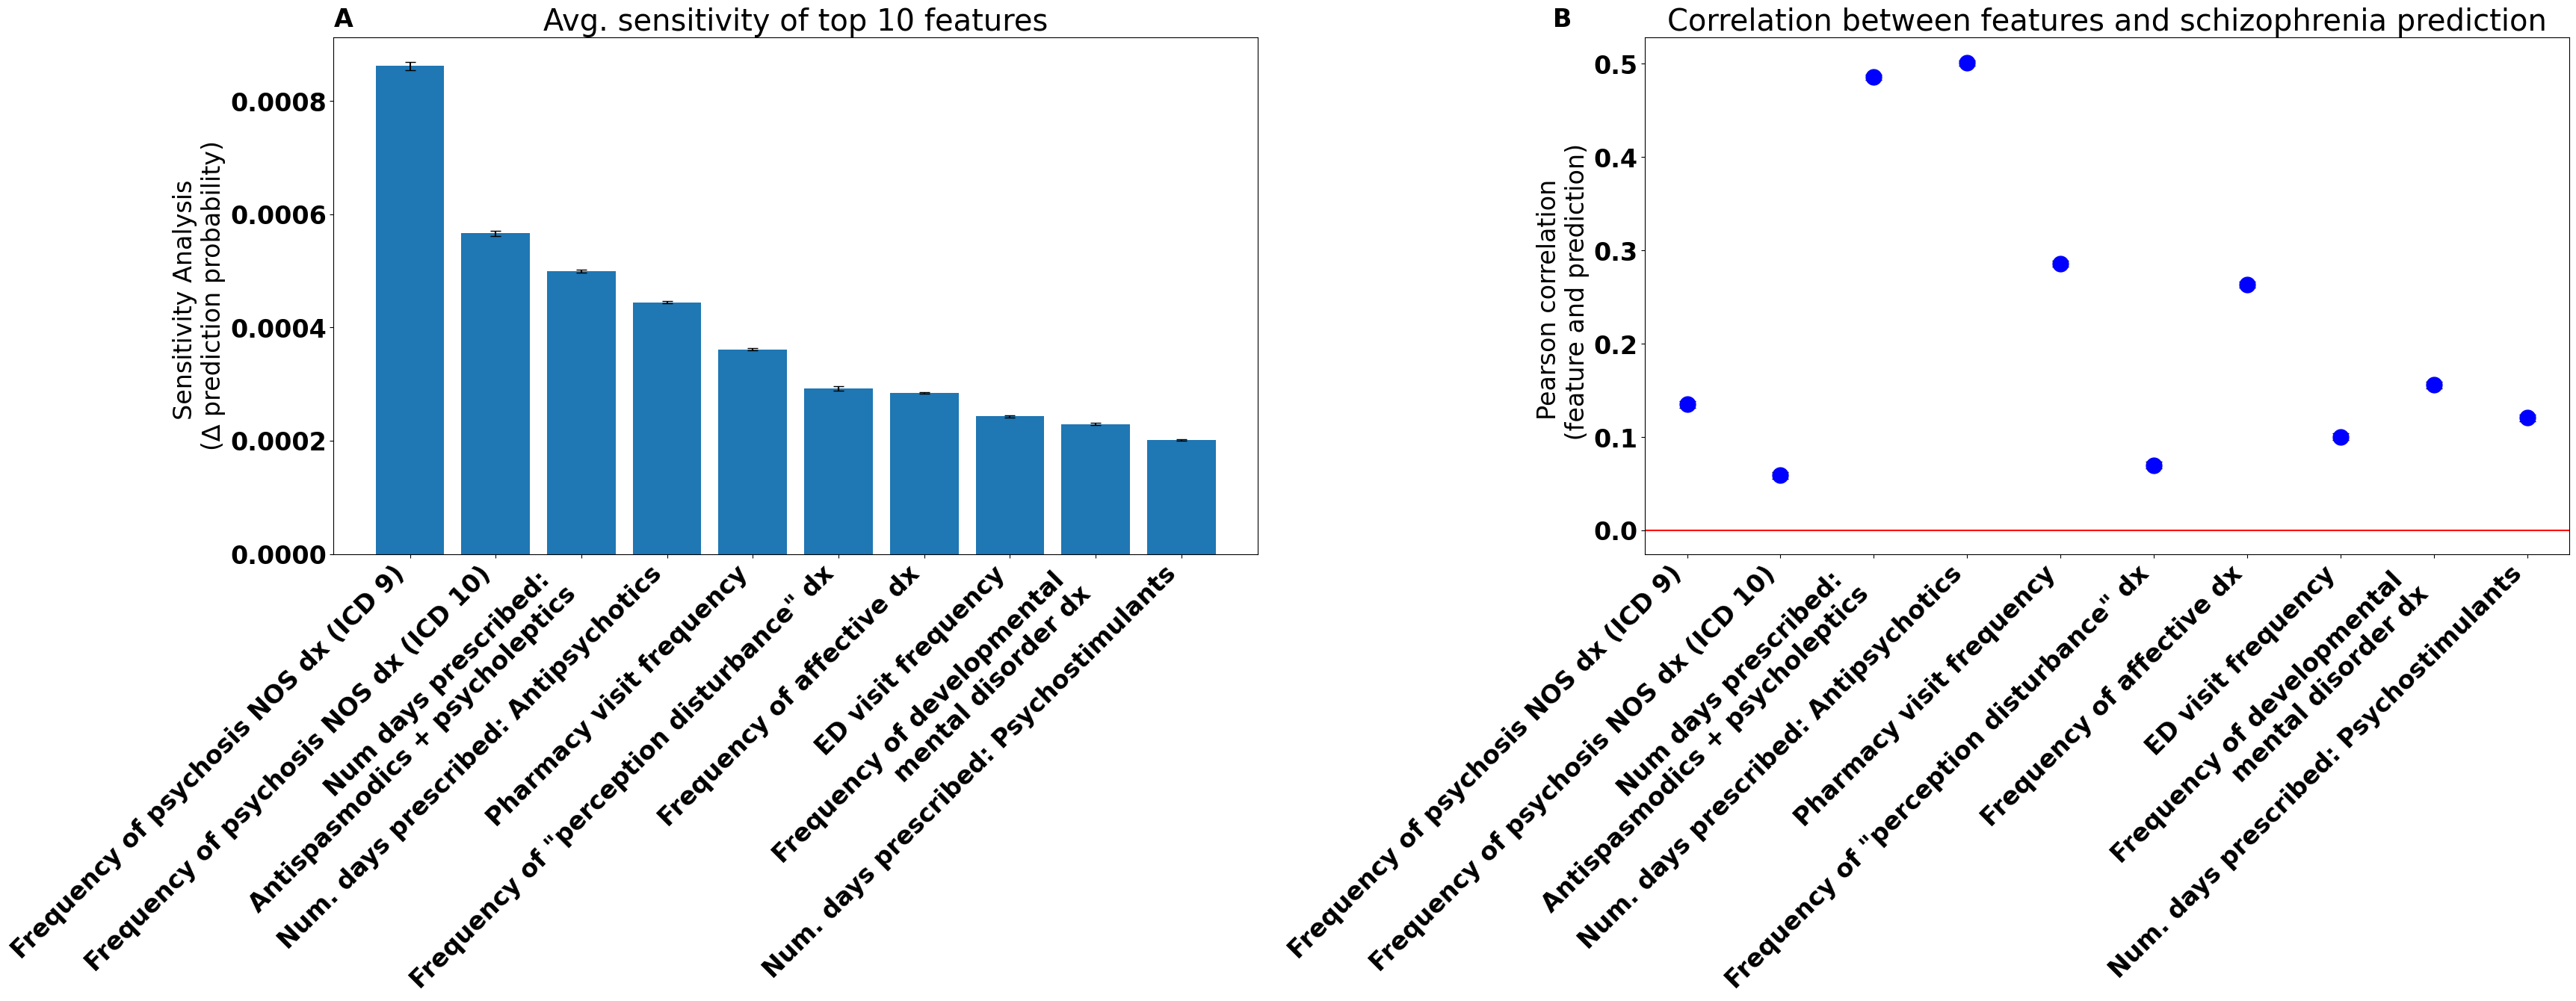

In [6]:
font = {'size': 24, 'weight':'bold'}
matplotlib.rc('font', **font)
x_label_coord = 0
y_label_coord = 1.02

x = np.arange(len(top10_rankings))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 14))
matplotlib.rc('font', **font)
ax1.bar(x, top10_rankings['mean_scores'], yerr=top10_rankings['overall_sem'], capsize=5)
ax1.set_ylabel('Sensitivity Analysis \n(∆ prediction probability)')
ax1.set_title('Avg. sensitivity of top 10 features')
ax1.set_xticks(x)
ax1.set_xticklabels(top10_rankings['feature_name'], rotation=45, ha = 'right')
ax1.text(x_label_coord, y_label_coord, 'A', transform=ax1.transAxes, size=24, weight='bold')

matplotlib.rc('font', **font)
ax2.errorbar(x, correlation_results['Correlation'], yerr=[correlation_results['Correlation']-correlation_results['CI_Lower'], correlation_results['CI_Upper']-correlation_results['Correlation']], fmt='o', color='blue', ecolor='black', capsize=8, markersize=15)
ax2.axhline(0, color='red')  # Add a red line at 0
ax2.set_xticks(x)
ax2.set_xticklabels(top10_rankings['feature_name'], rotation=45, ha='right')
ax2.set_ylabel('Pearson correlation \n (feature and prediction)')
ax2.set_title('Correlation between features and schizophrenia prediction')
ax2.text(-0.1, y_label_coord, 'B', transform=ax2.transAxes, size=24, weight='bold')

plt.tight_layout()
plt.savefig(f'{output_folder}/feature_importance.pdf', dpi=300)
plt.show()

In [7]:
# earliest iter importance
iter10_mean_scores = df_scores['time_iter_10_mean'].loc[data_columns]
iter10_sem_scores = df_scores['time_iter_10_sem'].loc[data_columns]

iter10_mean_scores.name = 'mean_scores'
iter10_sem_scores.columns = ['sem_scores']
iter10_rankings = pd.DataFrame(iter10_mean_scores).merge(iter10_sem_scores, how = 'outer', left_index=True, right_index=True)

iter10_rankings = iter10_rankings.sort_values('mean_scores', ascending=False)
iter10_rankings = iter10_rankings.sort_values('mean_scores', ascending=False).iloc[0:10]
print(iter10_rankings.index)

iter10_rankings['feature_name'] = ['ED visit frequency', 'Frequency of child examination', 'HDL Cholesterol lab frequency',
                                   'Frequency of inflammation dx (any system)', 'Frequency of preventitive medicine evaluation', 'Pharmacy visit frequency', 
                                   'Num. days prescribed: \nAntispasmodics + psycholeptics', 'Num. days prescribed: Antibiotics', 
                                   'Frequency of acute respiratory dx', 'Unspecified procedure']

# earliest iter importance
iter70_mean_scores = df_scores['time_iter_70_mean'].loc[data_columns]
iter70_sem_scores = df_scores['time_iter_70_sem'].loc[data_columns]

iter70_mean_scores.name = 'mean_scores'
iter70_sem_scores.columns = ['sem_scores']
iter70_rankings = pd.DataFrame(iter70_mean_scores).merge(iter70_sem_scores, how = 'outer', left_index=True, right_index=True)

iter70_rankings = iter70_rankings.sort_values('mean_scores', ascending=False)
iter70_rankings = iter70_rankings.sort_values('mean_scores', ascending=False).iloc[0:10]
print(iter70_rankings.index)
iter70_rankings['feature_name'] = ['Num. days prescribed: \nAntispasmodics + psycholeptics', 'Pharmacy visit frequency',
                                  'Num. days prescribed: Antipsychotics','Frequency of affective dx',
                                  'Frequency of developmental \nmental disorder dx', 'ED visit frequency',
                                  'Num. days prescribed: Psychostimulants', 'Num. days prescribed: \nAntiadrenergic agents',
                                  'Num. days prescribed: \nAnticholinergic agents', 'Frequency of Psychosis NOS dx (ICD 9)']


Index(['9203_ALL_num_visits', 'Child examination_procedure',
       'High density lipoprotein cholesterol measurement_lab',
       'Inflammation of specific body systems_conds',
       'Periodic comprehensive preventive medicine reevaluation and management of an individual including an age and gender appropriate history, examination, counseling/anticipatory guidance/risk factor reduction interventions, and the ordering of laboratory/d..._procedure',
       '581458_ALL_num_visits',
       'ANTISPASMODICS IN COMBINATION WITH PSYCHOLEPTICS_meds',
       'BETA-LACTAM ANTIBACTERIALS, PENICILLINS_meds',
       'Acute respiratory disease_conds', 'No matching concept_procedure'],
      dtype='object', name='feature')
Index(['ANTISPASMODICS IN COMBINATION WITH PSYCHOLEPTICS_meds',
       '581458_ALL_num_visits', 'ANTIPSYCHOTICS_meds', 'Mood finding_conds',
       'Developmental mental disorder_conds', '9203_ALL_num_visits',
       'PSYCHOSTIMULANTS, AGENTS USED FOR ADHD AND NOOTROPICS_meds',
  

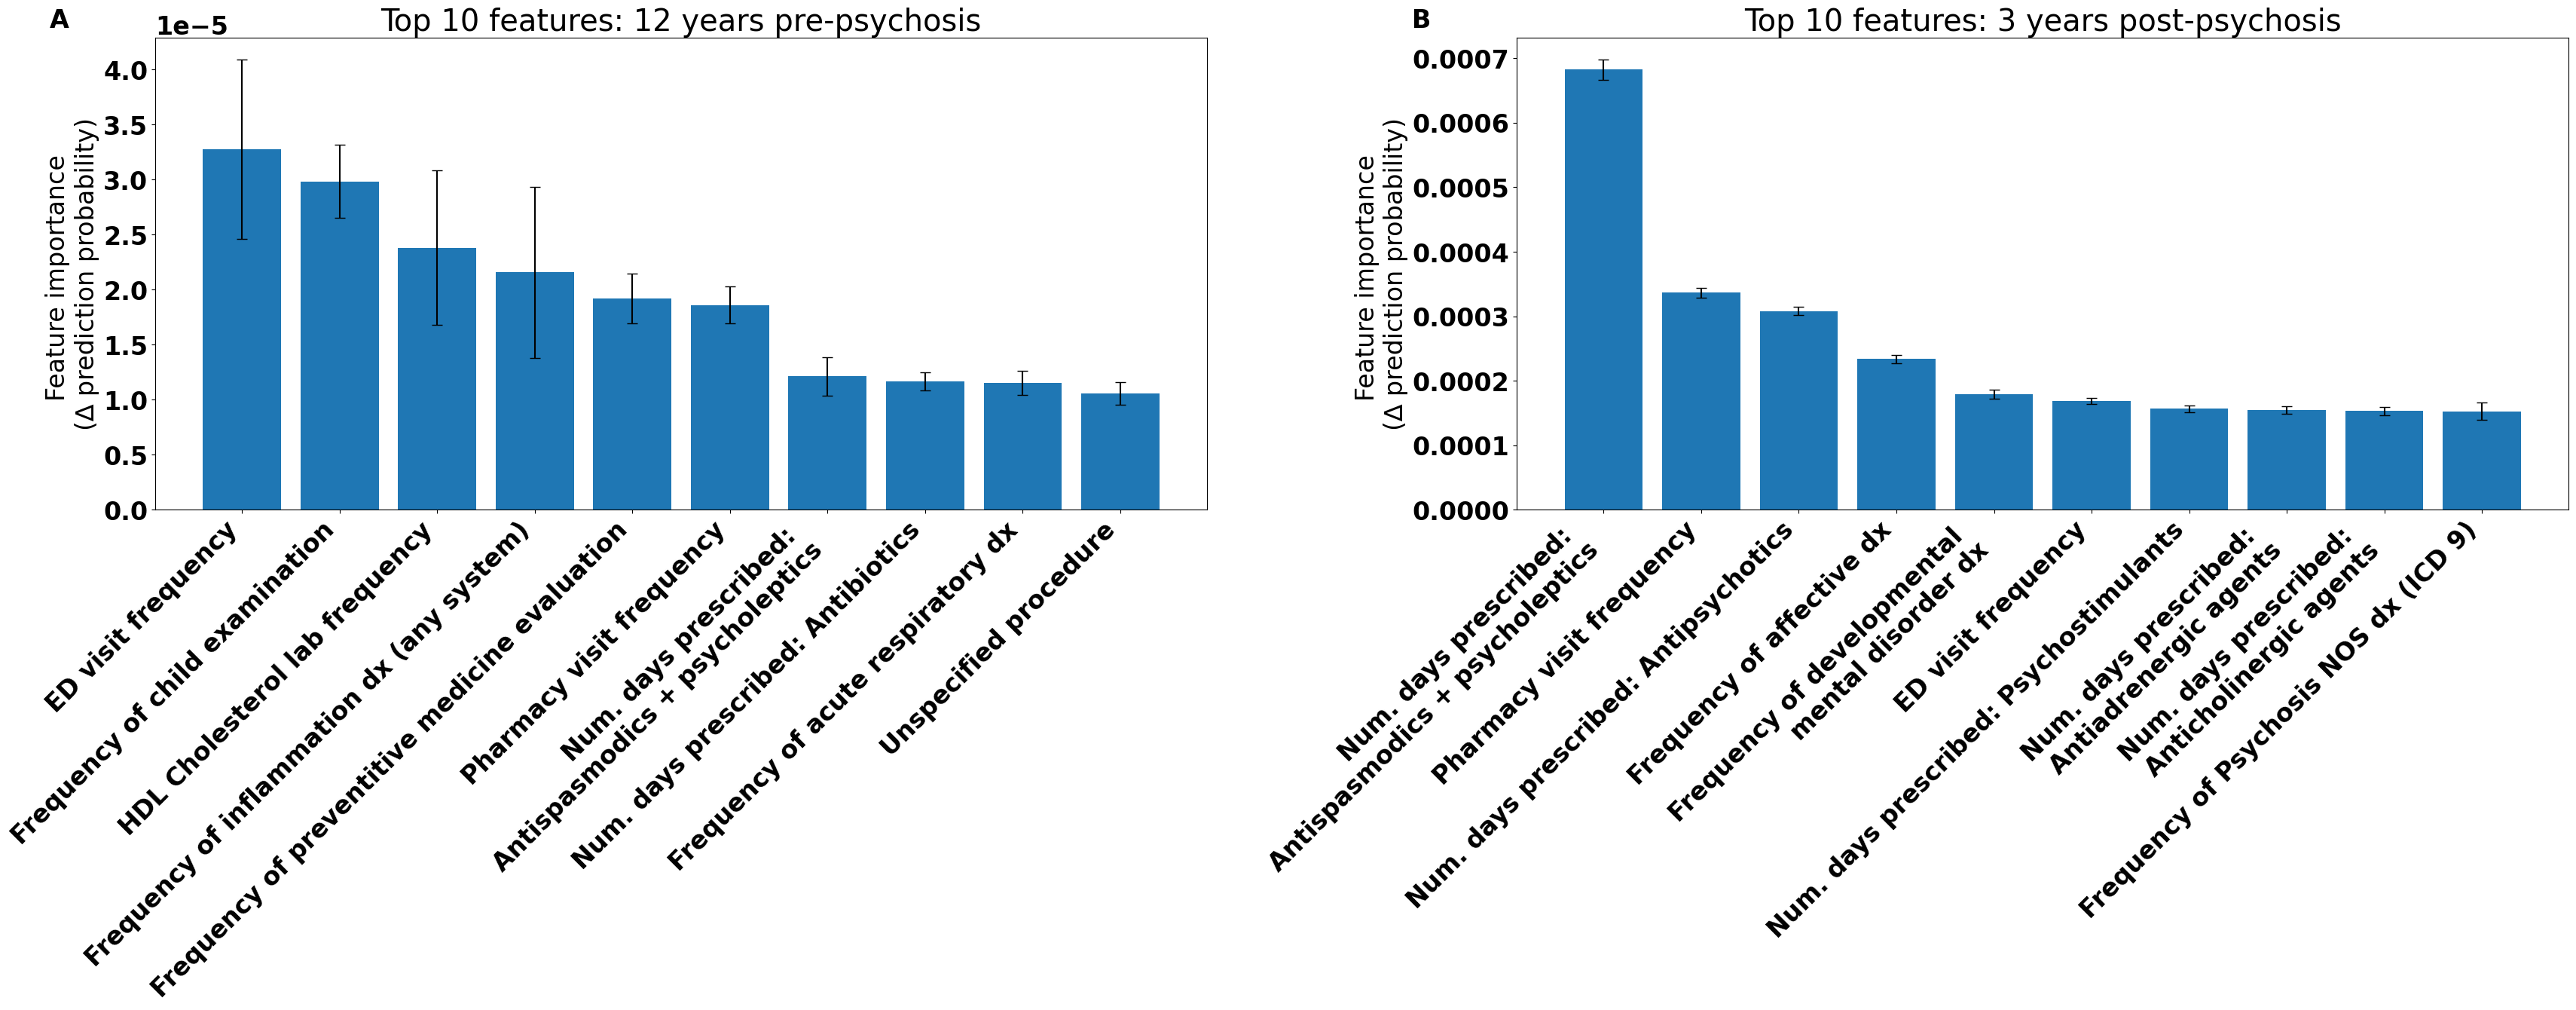

In [8]:
font = {'size': 24, 'weight':'bold'}
matplotlib.rc('font', **font)
x_label_coord = 0
y_label_coord = 1.02

x = np.arange(len(top10_rankings))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 14))
matplotlib.rc('font', **font)
ax1.bar(x, iter10_rankings['mean_scores'], yerr=iter10_rankings['time_iter_10_sem'], capsize=5)
ax1.set_ylabel('Feature importance \n(∆ prediction probability)')
ax1.set_title('Top 10 features: 12 years pre-psychosis')
ax1.set_xticks(x)
ax1.set_xticklabels(iter10_rankings['feature_name'], rotation=45, ha = 'right')
ax1.text(-0.1, y_label_coord, 'A', transform=ax1.transAxes, size=24, weight='bold')

matplotlib.rc('font', **font)
ax2.bar(x, iter70_rankings['mean_scores'], yerr=iter70_rankings['time_iter_70_sem'], capsize=5)
ax2.set_ylabel('Feature importance \n(∆ prediction probability)')
ax2.set_title('Top 10 features: 3 years post-psychosis')
ax2.set_xticks(x)
ax2.set_xticklabels(iter70_rankings['feature_name'], rotation=45, ha = 'right')
ax2.text(-0.1, y_label_coord, 'B', transform=ax2.transAxes, size=24, weight='bold')

plt.tight_layout()
plt.savefig(f'{output_folder}/feature_importance_beginningend.pdf', dpi=300)
plt.show()